## Module 8: Dimensionality Reduction and Autoencoders

Eva Dyer, BMED 6517

___


Outline:
- *PCA Algorithm*
- *UCI Digits Dataset*: In order to illustrate dimensionality reduction we will use one of the most widely used toy datasets in machine learning: a database of hand-written digits.
- *Applying PCA to images in Python* - Analysis step
- *Kernel PCA*
- *Isomap*

#### 1. What is dimensionality reduction?
- Dimensionality reduction is the process of reducing the number of independendent variables under consideration while maintaining the properties of the statistical distribution of the underlying data.
- Can be used to extract/generate features from data, to get a better intuitive understanding of data, or to compress data.
- Different ways to categorize dimensionality reduction methods:
   - **Supervised or unsupervised**
   - **Linear or nonlinear**, depending on what mapping is used to reduce the dimensionality and as a result what kind of high-dimensional structures can be captured.
   - **Global or local**, based on what kind of structure the mapping focuses on preserving.


#### 2. Quick math detour

##### 2.1. Co-variance

Assume we have an $N \times d$ data matrix $\mathbf{X}$ with $N$ samples which each have $d$ features, and let's define $\mathbf{X}_i$ as the $i$th feature, or equivalently the $i$th column of $\mathbf{X}$.

Recall that the mean of this feature is defined as:
$$\mathbf{\bar X}_i = \frac{1}{N} \sum_{n=1}^N \mathbf{X}_{n,i}$$

The variance of this feature is defined as the mean squared difference between each sample and the mean:
$$V(\mathbf{X}_i) = \frac{1}{N} \sum_{n=1}^N (\mathbf{X}_{n,i} - \mathbf{\bar X}_i)^2$$

The covariance between the $i$th and $j$th features is defined as:
$$\Sigma_{i,j} = Cov(\mathbf{X}_i, \mathbf{X}_j) = \frac{1}{N} \sum_{n=1}^N (\mathbf{X}_{n,i} - \mathbf{\bar X}_i)(\mathbf{X}_{n,j} - \mathbf{\bar X}_j)$$

When $i = j$, this is just the variance of feature $\mathbf{X}_i$.

We can naturally arrange all of these covariances into a $d \times d$ matrix, which we'll call $\Sigma$. This matrix is called the covariance matrix of $\mathbf{X}$. If the columns of $\mathbf{X}$ have 0 mean, we can calculate the feature-wise covariance matrix very easily:

$$\Sigma_d = \mathbf{X}^T \mathbf{X}$$


The sample-wise covariance (Gram matrix), which tells us how different examples are related to one other. This is an $N \times N$ matrix, which also has a simple form if the rows of $X$ have 0 mean:

$$\Sigma_N = \mathbf{X} \mathbf{X}^T$$

##### 2.2. Example

Now, let's see what this looks like if we generate different multi-variate normal distributions with pre-specified covariances.

In [ ]:
def generate_multivariate_normal():
    rng = np.random

    cov1 = np.array([[4, 0], [0, 4]])
    X1 = rng.multivariate_normal(mean=[0, 0], cov=cov1, size=500)

    cov2 = np.array([[4, 0], [0, 1]])
    X2 = rng.multivariate_normal(mean=[0, 0], cov=cov2, size=500)

    cov3 = np.array([[1, 0], [0, 4]])
    X3 = rng.multivariate_normal(mean=[0, 0], cov=cov3, size=500)

    cov4 = np.array([[3.5, 2.5], [2.5, 3.5]])
    X4 = rng.multivariate_normal(mean=[0, 0], cov=cov4, size=500)

    cov5 = np.array([[3.5, -2.5], [-2.5, 3.5]])
    X5 = rng.multivariate_normal(mean=[0, 0], cov=cov5, size=500)
    return [cov1, cov2, cov3, cov4, cov5], [X1, X2, X3, X4, X5]

covs, Xs = generate_multivariate_normal()

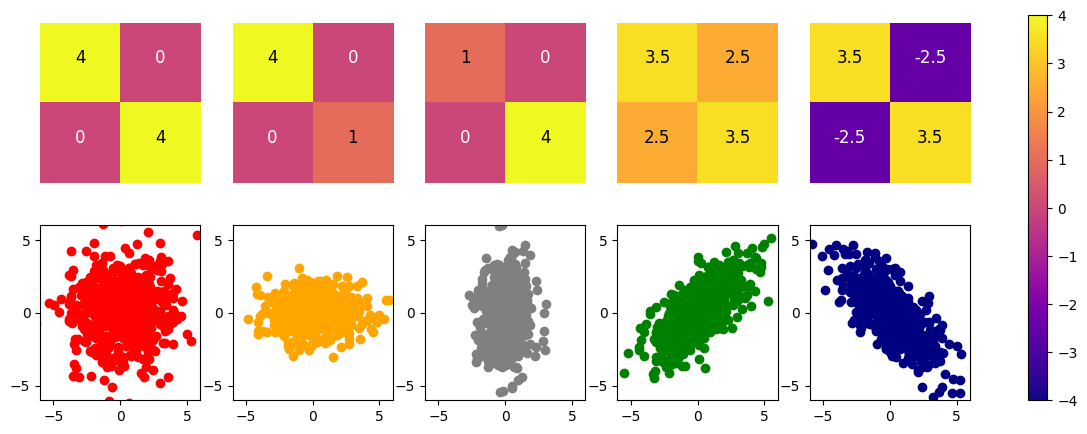

In [ ]:
# plot covariance
from matplotlib import colors


fig, axes = plt.subplots(2, 5, figsize=(15, 5))

# plot covariance matrices
for i in range(len(covs)):
    im = axes[0, i].imshow(covs[i], cmap='plasma', vmin=-4, vmax=4)

    # turn axis off
    axes[0, i].set_axis_off()

    # add values on image
    for k in range(2):
        for l in range(2):
            color = "white" if covs[i][k, l] <= 0 else "black"
            axes[0, i].text(k, l, covs[i][k, l], horizontalalignment="center",
                            color=color, size='large')

# make scatter plots
colors = ['red', 'orange', 'grey', 'green', 'navy']
for i in range(len(Xs)):
    axes[1, i].scatter(*Xs[i].T, c=colors[i])
    axes[1, i].set_xlim([-6, 6])
    axes[1, i].set_ylim([-6, 6])
    axes[1, i].locator_params(nbins=2)

fig.colorbar(im, ax=axes)
plt.show()

##### 2.3. Eigenvalue and singular value decompositions

<br>

**Eigenvalue decomposition**

Recall that an eigenvector ${\bf v}$ of a matrix ${\bf A}$ satisfies the following equation:
$$ {\bf A} {\bf v} = \lambda {\bf v},$$
where $\lambda$ is the corresponding eigenvalue.

- **Eigenvalue decomposition (EVD)** of a square matrix ${\bf A}$:
$${\bf A} = \sum_{i = 1}^d \lambda_i \mathbf{v}_i \mathbf{v}_i^T,$$
where ${\bf v}_i$ is the $i^{\rm th}$ eigenvector of ${\bf A}$ and $\lambda_i$ is the $i^{\rm th}$ eigenvalue.
<br>
- **Singular value decomposition (SVD)** of an arbitrary (rectangular matrix) ${\bf A}$:

$${\bf A} = {\bf U} {\bf \Sigma} {\bf V}^T,$$
$\hspace{8mm}$where ${\bf U}$ are the left singular vectors, ${\bf V}$ are the right singular vectors, and $\Sigma$ is a diagonal matrix with the singular values along its diagonal.
<br>
- **Equivalence of the SVD and EVD:** Let's compute SVD of covariance of AA' and A'A and see how they are related! *



##### 2.4. Computing the eigenvalues in linalg

To calculate eigenvalues of a matrix, we can use the `linalg` submodule.

`eig` computes the eigen values and the corresponding right eigenvectors. The eigenvectors corresponding to the $n$th eigenvalue (stored in `eigen_vals[n]`) is the $n$th column in `eigen_vecs`, i.e., `eigen_vecs[:, n]`.

In [ ]:
from numpy import linalg as LA

A = np.array([[-1, 2], [3, -1]])
eigen_vals, eigen_vecs = LA.eig(A)

print('Eigen values of A:', eigen_vals)
print('Eigen vectors of A:\n', eigen_vecs)

Eigen values of A: [ 1.44948974 -3.44948974]
Eigen vectors of A:
 [[ 0.63245553 -0.63245553]
 [ 0.77459667  0.77459667]]


#### 3. Principal Component Analysis

PCA is one of the simplest and most popular dimensionality reduction strategies, and the principles behind it underlie almost all of the more advanced techniques we'll study, so we'll use it to introduce these ideas.

##### 3.1. PCA: Outline and Steps

1. Compute the covariance of your data
2. Solve for the eigenvectors of your data covariance
3. Top k- eigenvectors form the basis for your low rank approximation

As a simple example, let's apply PCA to the popular California wine dataset.

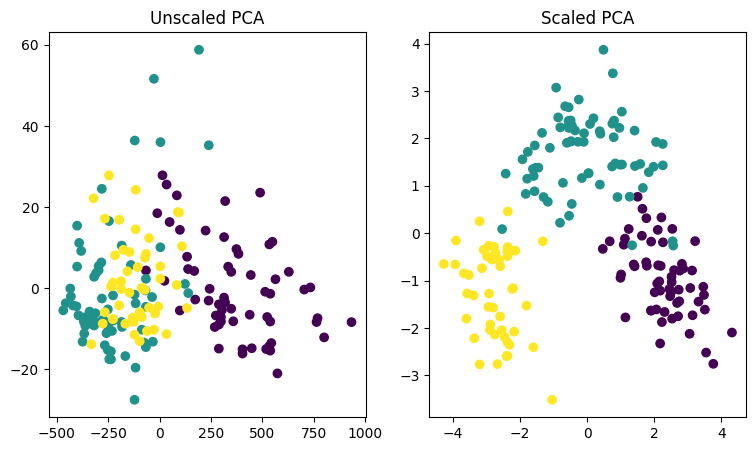

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA

feats, labels = load_wine(return_X_y=True)

feats_upc = PCA(n_components=2).fit_transform(feats)
feats_spc = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(feats))

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
axes[0].scatter(feats_upc[:, 0], feats_upc[:, 1], c=labels)
axes[0].set_title('Unscaled PCA')
axes[1].scatter(feats_spc[:, 0], feats_spc[:, 1], c=labels)
axes[1].set_title('Scaled PCA')
plt.show()

**Homework Question:** Why are the resulting outputs different? Provide a justification.

> Reply here

##### 3.2. Application to UCI Digits dataset

Now let's run PCA on the UCI digits dataset:

(1797, 64)
(1797,)


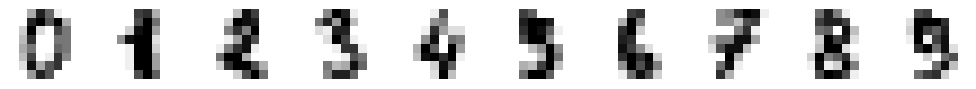

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits,classes = load_digits(return_X_y=True)
print(digits.data.shape)
print(classes.shape)
X_orig = np.array(digits.data)
y = classes

X = (X_orig - X_orig.min(axis=0))/(X_orig.max() - X_orig.min())

fig, axes = plt.subplots(1, 10, figsize=(10, 1))

for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(8,8), cmap='binary')
    ax.set_axis_off()
plt.tight_layout()

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import SparsePCA, KernelPCA
from sklearn.decomposition import PCA

k=2

lPCA = PCA(n_components=k)
lPCA.fit(X)
X_PCA = lPCA.transform(X)

##### 3.3. Interpretation of PCA as optimal low-rank matrix approximation

PCA is an **unsupervised**, **linear**, and **global** technique. The objective function for PCA is:

$$\min_{\bf A}~~ \|\mathbf{X} - \mathbf{A}\|_F \quad {\rm subject~to} \quad {\rm rank}({\bf A}) = k$$
where $\| {\bf M} \|_F = \sum_i \sum_j \mathbf{M}_{ij}^2 $is the "Frobenius norm" and $\mathbf{A}$ is a "low rank" (rank k) approximation of $\mathbf{X}$. In other words we are looking for the closest rank-$k$ matrix to the original matrix $\mathbf{X}$.

The solution to this problem is given by the SVD:
$${\bf A} = {\bf U}_k {\bf \Sigma}_k {\bf V}_k^T,$$
where ${\bf U}_k$ contains the leading k left singular vectors of ${\bf Y}$ and ${\bf V}_k^T$ contains the leading k right singular vectors of ${\bf Y}$.

The rank of a matrix is also determined by its non-zero eigenvalues. Another way to think about PCA for dimensionality reduction is that it uses the eigenvectors corresponding to only the $k$ largest eigenvalues of the covariance matrix to reconstruct the data. If we remember back to earlier lectures, the eigenvalues of the covariance data also give us the variance of the data along the principal component axes. Therefore we find that PCA gives a rank-$k$ approximation of the data that **retains the maximum possible amount of variance**.

*Note:* We will not derive the connection between this minimization problem and the covariance matrix eigenvalues here, but details are available in Hastie 14.5.

#### 4. Unsupervised evaluation metrics

- Loss function
  - How well can you reconstruct your input data? In PCA - how much of the variance in your data have you captured?
- Leave-one-out prediction
  - How well you can predict a held-out test sample?
- Clustering metrics
  - Is the data well separated or clusterable after projection?
  - Silhouette score, Rand Index and Adjusted Rand Index
- Stress under projection
  - If we assume nearest-neighbors in Euclidean space are a good indicator of nearness, how much does the projection distort the neighbors?

**Homework Question:**

Provide code below to compute some of these metrics for the scaled and unscaled Wine dataset above in 2.1. Discuss the advantages of the different measures in this particular example and how the metrics vary for the two cases.

In [ ]:
# Provide an example with different losses and metrics



#### 5. What lies beyond PCA

PCA is one of the most widely used techniques in dimensionality reduction because it is:

* **Unsupervised** - We did not use the labels to determine the statistics.
* **Projectable** - It is also easy to project a new data point into the reduced dimensional space.
* **Invertible** - It is easy to move from the low-dimensional space to the high dimensional space.
* **Closed-form solution** - The SVD provides an efficient solution to the problem.

However, its weakness is that it is linear in the original space, assumes a Gaussian noise model on the data, and builds an orthogonal set of basis vectors. Thus, when datasets have additional structure, either in terms of the signal or noise model, the PCA model can be extended in a number of useful ways.


##### 5.1. Sparse PCA and other variants

There are many variants of PCA and other forms of linear dimensionality reduction, including:
* **Sparse PCA** - constrain PCs or coefficients to be sparse (small number of non-zeros)
* **Linear discriminant analysis** - supervised classification-based PCA that maximizes inter-class variance
* **Robust PCA** - good for cases where there is sparse data and/or large errors/outliers

Let's go back to our UCI digits dataset and compare the results obtained for these variants.

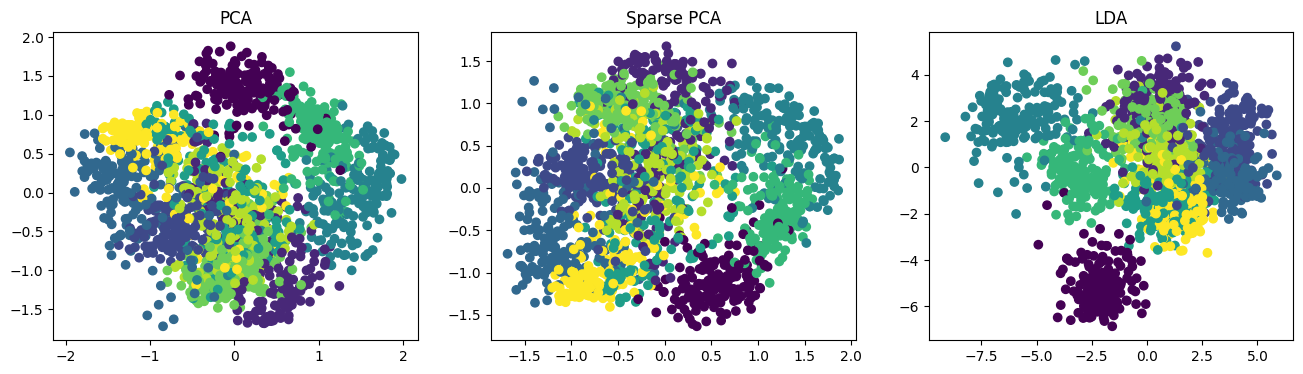

In [ ]:
sPCA = SparsePCA(n_components=k)
sPCA.fit(X)
X_sPCA = sPCA.transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X,y)
X_lda = lda.transform(X)

fig, axes = plt.subplots(1,3,figsize=(16,4))

axes[0].scatter(X_PCA[:,0], X_PCA[:,1],c=y)
axes[0].set_title('PCA')

axes[1].scatter(X_sPCA[:,0], X_sPCA[:,1],c=y)
axes[1].set_title('Sparse PCA')

axes[2].scatter(X_lda[:,0], X_lda[:,1],c=y)
axes[2].set_title('LDA')

plt.show()

##### 5.2. Kernel PCA

The solution to non-linearity in PCA is a familiar one: using a "kernel" to perform PCA in an even-higher dimensional space that captures non-linearities. This makes kernel PCA the first (and in some ways the simplest) **non-linear** technique we'll look at. The concept here is that rather than using the covariance matrix the eigenvalues of a "kernel matrix" are used:

$$\mathbf{K}_{ij} = \kappa(\vec{x}_i, \vec{x}_j)$$ where $\kappa$ is a kernel function, such as the radial basis function:

$$\kappa_{rbf}(\mathbf{x}_i, \mathbf{x}_j) = \exp(-\gamma ||\mathbf{x}_i - \mathbf{x}_j||^2)$$

We will not go into the details, but instead show an example of how it works with the `scikit-learn` implementation:

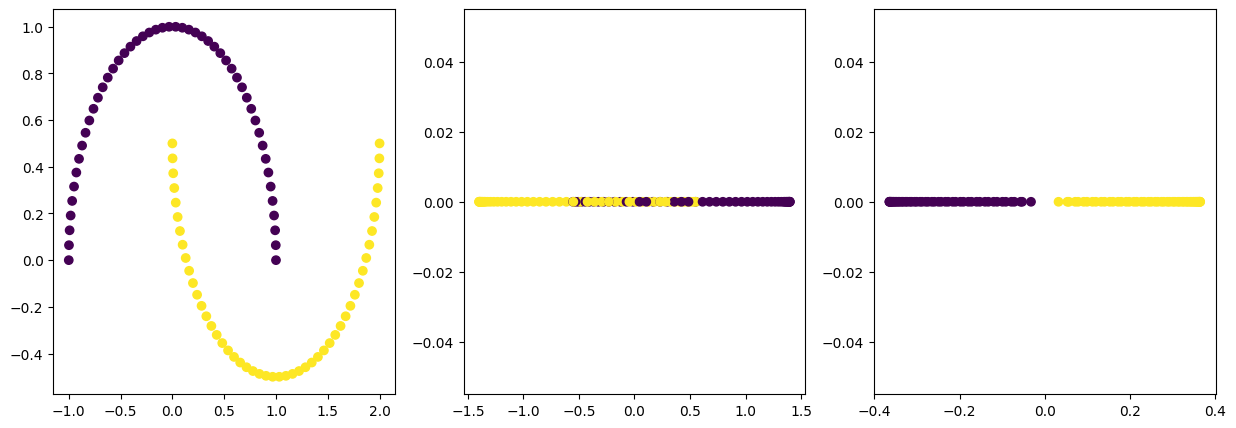

In [ ]:
from sklearn.datasets import make_moons
from sklearn.decomposition import KernelPCA, PCA

k = 1
X_m, y_m = make_moons(n_samples=100, random_state=0)
kPCA = KernelPCA(n_components=k, kernel='rbf', gamma=15, fit_inverse_transform=True)
lPCA = PCA(n_components=k)

lPCA.fit(X_m)
X_PCA = lPCA.transform(X_m)

kPCA.fit(X_m)
X_kPCA = kPCA.transform(X_m)

fig,axes = plt.subplots(1,3,figsize=(15,5))
axes[0].scatter(X_m[:,0], X_m[:,1], c=y_m)
axes[1].scatter(X_PCA, np.zeros(X_PCA.size), c=y_m)
axes[2].scatter(X_kPCA, np.zeros(X_PCA.size), c=y_m)
plt.show()

**Question: **
> How could $\gamma$ be selected in the supervised setting? In the unsupervised setting?

Kernel PCA is also invertible, much like regular PCA:

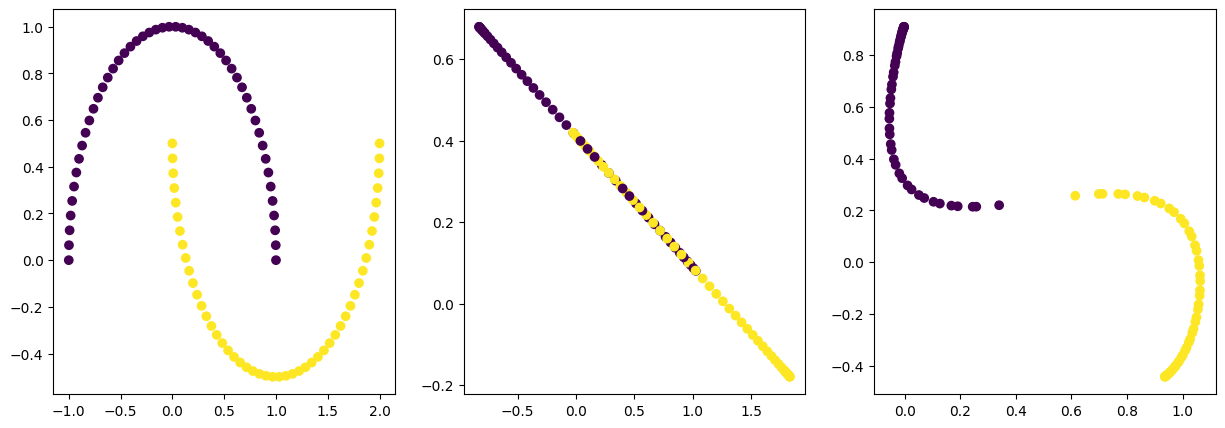

In [ ]:
X_PCA_reconstruct = lPCA.inverse_transform(X_PCA)
X_kPCA_reconstruct = kPCA.inverse_transform(X_kPCA)

fig,axes = plt.subplots(1,3,figsize=(15,5))
axes[0].scatter(X_m[:,0], X_m[:,1], c=y_m)
axes[1].scatter(X_PCA_reconstruct[:,0], X_PCA_reconstruct[:,1], c=y_m)
axes[2].scatter(X_kPCA_reconstruct[:,0], X_kPCA_reconstruct[:,1], c=y_m)
plt.show()

##### 5.3 Multi-dimensional scaling (MDS)

One prototype dimensionality reduction technique is **multi-dimensional scaling**. The principle is that the "stress" is directly minimized. The stress is given by:

$$S(\mathbf{x}_{0}, \mathbf{x}_1, \mathbf{x}_2, ... \mathbf{x}_n) =  \left(\frac{\sum_{i=0}^n \sum_{i < j}(d_{ij} - ||\mathbf{x}_i - \mathbf{x}_j||)^2}{\sum_{i=0}^n \sum_{i < j} d_{ij}^2}\right)^{1/2}$$

where $d_{ij}$ is the distance in the high-dimensional space and $\vec{x}$ is the vector in the low-dimensional space. A typical choice is to use the Euclidean distance to compute $d_{ij}$, but there are variants of MDS that use other distance metrics.

In [ ]:
from sklearn.manifold import MDS

X_mds = MDS(n_components=2, n_init=1, max_iter=100).fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


#### 6. Manifold learning techniques

Manifold learning approaches utilize distance metrics between points to define their similarity, and then seek to minimize the difference between distance metrics in the high- and low-dimensional spaces. The advantage of distance metrics over variance is that the **local structure** of data (distances between points) can be more easily exploited. This makes manifold learning techniques much better suited for highly non-linear datasets.


##### 6.1. Geodesic distances

One natural way to capture local structure is with something you should be very familiar with, a neighborhood graph. This is very similar to the idea underlying the k-nearest neighbors classifier that we studied in the Classification module.



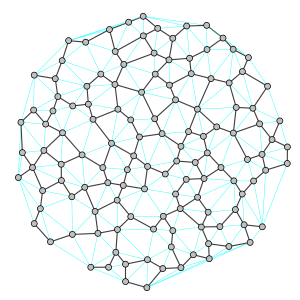

The distances between a point and its neighbors is just their Euclidean distance (or some other metric). However, the geodesic distance between any two points that aren't directly connected is defined as the distance between them by traversing this graph, so it's always greater than or equal to the actual distance between the points in question.

This means geodesic distance is an effective way to measure the distance you'd have to travel along the surface of a structure that can be connected by a neighborhood graph. For structures that fold back on themselves, this can be a powerful tool to impose some kind of linearity on them.

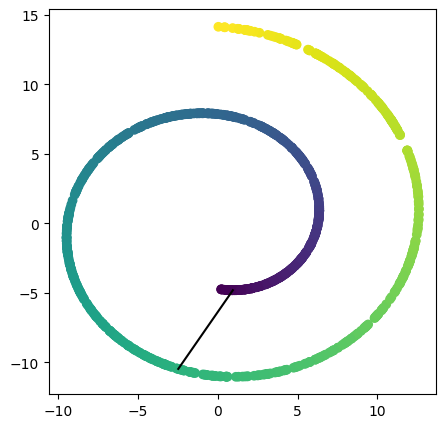

In [ ]:
from sklearn.datasets import make_swiss_roll

swiss_roll, t = make_swiss_roll(n_samples=1000, random_state=42)

x1 = swiss_roll[10]
x2 = swiss_roll[200]
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(swiss_roll[:, 0], swiss_roll[:, 2], c=t)
ax.plot([x1[0], x2[0]], [x1[2], x2[2]], c='k')
plt.show()

##### 6.2. Isomap

Isomap consists of three key steps:

- Step 1: Construct a nearest-neighbors graph of the dataset.
- Step 2: Use Dijkstra's algorithm to find the geodesic distance between every pair of points by traversing this nearest neighbors graph.
- Step 3: Apply multi-dimensional scaling to the geodesic distance matrix to get the new coordinates of the dataset.

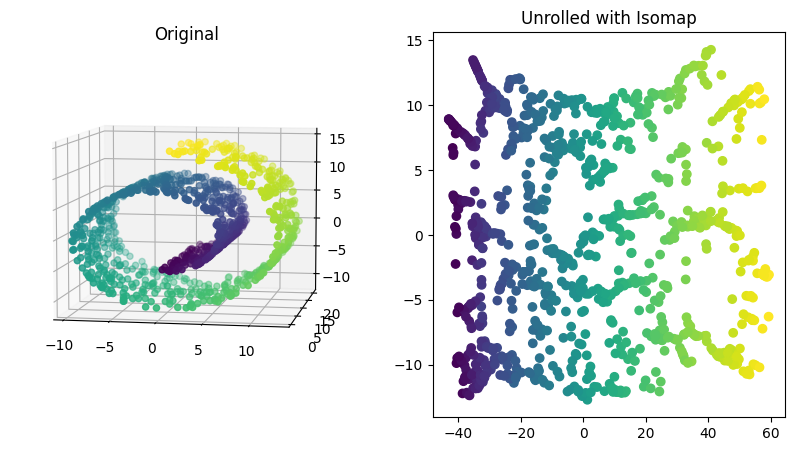

In [ ]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D

swiss_roll, t = make_swiss_roll(n_samples=1000, random_state=42)
swiss_unroll = Isomap(n_components=2).fit_transform(swiss_roll)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2], c=t)
ax.view_init(elev=7, azim=-80)
ax.set_title('Original')
ax = fig.add_subplot(122)
ax.scatter(swiss_unroll[:, 0], swiss_unroll[:, 1], c=t)
ax.set_title('Unrolled with Isomap')
plt.show()

##### 6.3. t-Stochastic Neighbor Embedding (tSNE)

Another popular manifold-based method is tSNE, or t-distribution stochastic neighbor embedding. This uses a probabilistic similarity metric based on the t-distribution, which makes it somewhat better suited to retain both local structure. We won't go into details but we can see how it performs:

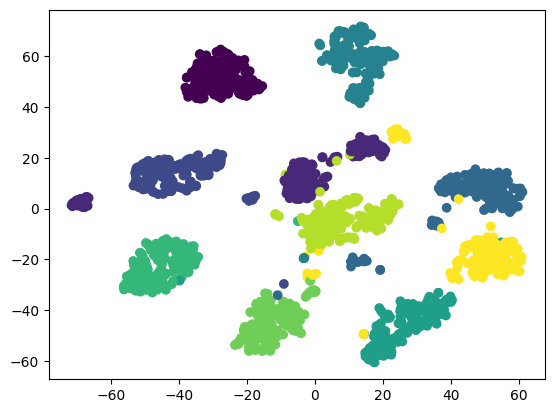

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=20.0,
            early_exaggeration=12.0,
            learning_rate=200.0,
            n_iter=1000,
            init='random')

X_tsne = tsne.fit_transform(X)

fig, ax = plt.subplots()
ax.scatter(X_tsne[:,0], X_tsne[:,1], c=y)

Clusters are much more separable than MDS or PCA!

However, there are many hyper-parameters that don't have clear meaning (e.g. "perplexity"), and the outcome will depend on the initial guesses and the algorithms used. While tSNE can be powerful, it also typically requires substantial effort.


##### 6.4. Some other common manifold-based techniques include:

* Locally linear embedding (LLE)
* Spectral embedding
* Local tangent space alignment (LTSA)

[Comparison of these methods](http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html):



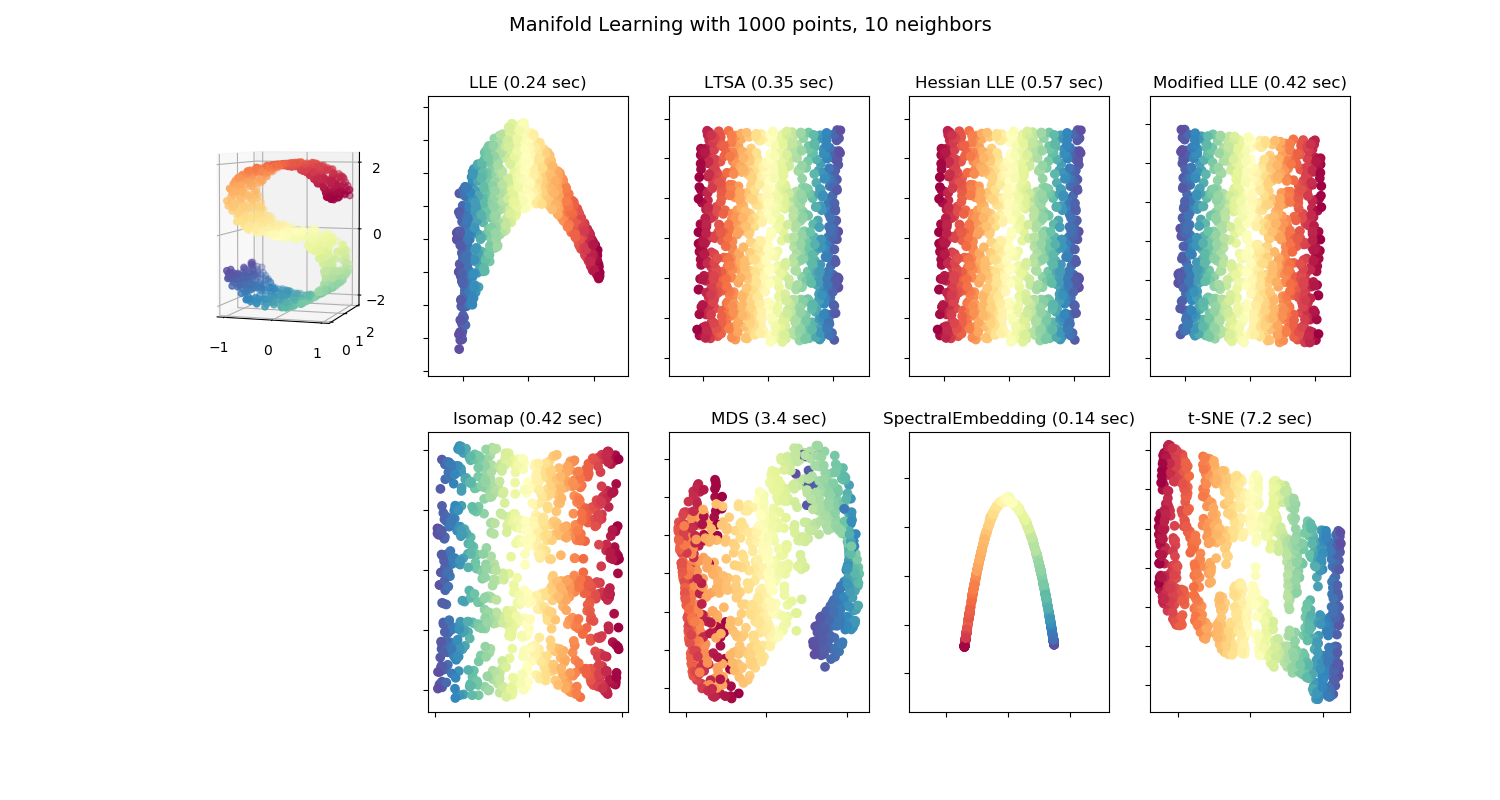

Manifold techniques can give powerful insight into the high-dimensional structure of data; however, most suffer from several key disadvantages:

* *Not projectable* - the low dimensional representation only applies to the training points.
* *Not invertible* - no way to move back to high-dimensional space
* *Slow* - manifold techniques use distance matrices and hence tend to scale as $N^2$

For these reasons manifold techniques are best for providing insight into the structure of the data, but usually need to be combined with other dimensionality reduction approaches for model construction.

#### 7. Deep Autoencoders

The final approach we will discuss is "autoencoding", which is the use of neural networks for dimensionality reduction.


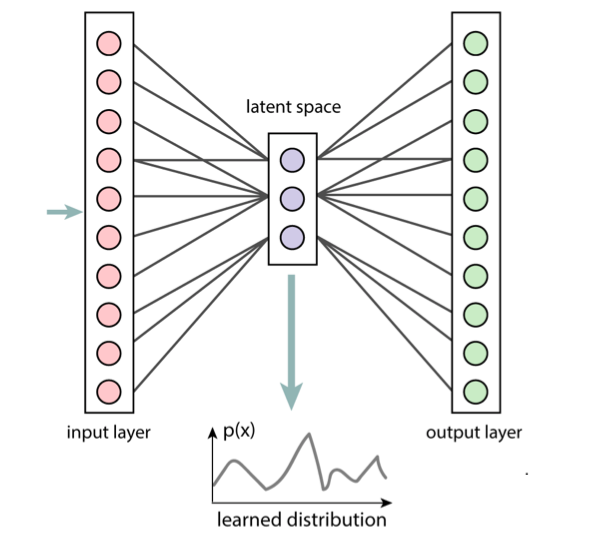

The idea is that you train a neural network with the same data as inputs and outputs, but use an intermediate hidden layer (or layers) with dimensionality smaller than the original data. This forces the data through a "bottleneck" where it is represented in a low-dimensional form. This has numerous advantages:

* projectable and invertible - the link between the high/low dimensional representation is defined by the neural net
* fast and scalable - neural networks are computationally efficient
* non-linear and unsupervised - the autoencoder learns the non-linear manifold without needing labels

However, the typical cautions of neural networks apply:

* extremely large training datasets needed
* architecture and hyperparameters need to be tuned/selected
* no intuitive link between low- and high-dimensional representations


#### 8. Overview and comparison of different approaches

**Summary:**
* High-dimensional data is common in engineering: images, signals, etc.
    
* Dimensionality reduction techniques can be used to:
    - Visualize data
    - Engineer model features
    - Improve model efficiency
    - Compress data

* Principal component analysis is a prototype for dimensionality reduction that is:
    - Unsupervised
    - Projectable
    - Invertible

* Principal component analysis can be thought of as:
    - determining the best rank-k approximation of a matrix based on the Frobenius norm
    - determining the rank-k matrix that retains the maximum possible variance of the original data
    - A projection based on the largest k eigenvalues of the covariance matrix
   
* Three general approaches to dimensionality reduction were introduced:
    - Retaining variance (PCA-based approaches, global structure considered)
    - Retaining distances (manifold approaches, local structure emphasized)
    - Intermediate representation (autoencoders, neural-network based)


**Comparisons:**
A final comparison of all the methods we looked at on our digits dataset:

In [ ]:
from scipy.spatial.distance import pdist

def stress(X_reduced, X):
    D_red = pdist(X_reduced)
    D_tot = pdist(X)
    numerator = np.sum((D_tot - D_red)**2)
    denom = np.sum(D_tot**2)
    return np.sqrt(numerator/denom)

In [ ]:
X_pca = PCA(n_components=2).fit_transform(X)
X_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
X_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.5).fit_transform(X)
X_mds = MDS(n_components=2, n_init=1, max_iter=100).fit_transform(X)
X_iso = Isomap(n_components=2).fit_transform(X)
X_tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, init='random').fit_transform(X)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


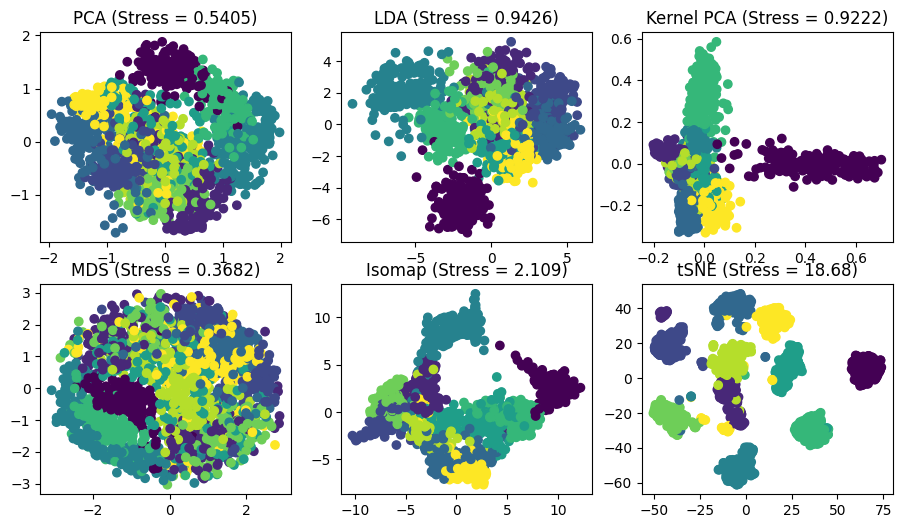

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(11, 6))
axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y)
axes[0, 0].set_title('PCA (Stress = {:.4g})'.format(stress(X_pca, X)))
axes[0, 1].scatter(X_lda[:, 0], X_lda[:, 1], c=y)
axes[0, 1].set_title('LDA (Stress = {:.4g})'.format(stress(X_lda, X)))
axes[0, 2].scatter(X_kpca[:, 0], X_kpca[:, 1], c=y)
axes[0, 2].set_title('Kernel PCA (Stress = {:.4g})'.format(stress(X_kpca, X)))
axes[1, 0].scatter(X_mds[:, 0], X_mds[:, 1], c=y)
axes[1, 0].set_title('MDS (Stress = {:.4g})'.format(stress(X_mds, X)))
axes[1, 1].scatter(X_iso[:, 0], X_iso[:, 1], c=y)
axes[1, 1].set_title('Isomap (Stress = {:.4g})'.format(stress(X_iso, X)))
axes[1, 2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
axes[1, 2].set_title('tSNE (Stress = {:.4g})'.format(stress(X_tsne, X)))
plt.show()

**Homework Assignment:**

For each method in the example above, say whether it is:

1. (i) supervised or unsupervised, (ii) linear or nonlinear,  (iii) local or global

> Reply here

2. Describe the pros and cons of using each method. What are the hyperparameters used in each of the approaches?

> Reply here

Contributors: Max Dabagia, Mehdi Azabou, Eva Dyer